In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
import random

# Loading Data

In [3]:
# Paths to the dataset folders
index_path = '/kaggle/input/india-stock-data-nse-1990-2020/Datasets/INDEX'
scrip_path = '/kaggle/input/india-stock-data-nse-1990-2020/Datasets/SCRIP'

# Load all CSV files in INDEX
index_data = {}
for file in os.listdir(index_path):
    if file.endswith('.csv'):
        index_name = os.path.splitext(file)[0]
        index_data[index_name] = pd.read_csv(os.path.join(index_path, file))

# Load all CSV files in SCRIP
scrip_data = {}
for file in os.listdir(scrip_path):
    if file.endswith('.csv'):
        scrip_name = os.path.splitext(file)[0]
        scrip_data[scrip_name] = pd.read_csv(os.path.join(scrip_path, file))

- Index Data: This contains information about various stock indices over the years.- Scrip Data: This includes individual stock data (scrips) for companies listed on the NSE from 1990 to 2020

- Both are dictionaries above.

In [4]:
# Example: Access NIFTY data from INDEX
nifty_data = index_data['NIFTY 100']  # Adjust based on the actual file name
print(nifty_data.head())

         Date  Open  High  Low    Close  Volume  Turnover
0  2003-01-01   0.0   0.0  0.0  1000.00     NaN       NaN
1  2003-01-02   0.0   0.0  0.0  1008.03     NaN       NaN
2  2003-01-03   0.0   0.0  0.0  1004.49     NaN       NaN
3  2003-01-06   0.0   0.0  0.0   999.85     NaN       NaN
4  2003-01-07   0.0   0.0  0.0   997.81     NaN       NaN


In [5]:
nifty_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4599 entries, 0 to 4598
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      4599 non-null   object 
 1   Open      4599 non-null   float64
 2   High      4599 non-null   float64
 3   Low       4599 non-null   float64
 4   Close     4599 non-null   float64
 5   Volume    3904 non-null   float64
 6   Turnover  3904 non-null   float64
dtypes: float64(6), object(1)
memory usage: 251.6+ KB


In [6]:
print(list(nifty_data.keys()))

['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Turnover']


In [7]:
# Convert Date column to datetime format for INDEX data
for name, df in index_data.items():
    df['Date'] = pd.to_datetime(df['Date'])

# Convert Date column to datetime format for SCRIP data
for name, df in scrip_data.items():
    df['Date'] = pd.to_datetime(df['Date'])

In [8]:
nifty_data

,Date,Open,High,Low,Close,Volume,Turnover
0,2003-01-01,0.00,0.00,0.00,1000.00,NaN,NaN
1,2003-01-02,0.00,0.00,0.00,1008.03,NaN,NaN
2,2003-01-03,0.00,0.00,0.00,1004.49,NaN,NaN
3,2003-01-06,0.00,0.00,0.00,999.85,NaN,NaN
4,2003-01-07,0.00,0.00,0.00,997.81,NaN,NaN
...,...,...,...,...,...,...,...
4594,2021-06-25,16058.95,16097.20,15998.55,16087.20,583841789.0,3.417749e+11
4595,2021-06-28,16141.45,16141.70,16032.75,16055.20,592658931.0,2.659160e+11
4596,2021-06-29,16050.50,16088.55,15966.85,15992.10,724862193.0,3.368474e+11
4597,2021-06-30,16020.90,16073.85,15945.55,15959.40,551617037.0,2.709824e+11


In [9]:
# Cleaning and preprocessing the data

def clean_data(df):
    # 1. Handle missing values in the 'Close' column
    def fill_missing_close(row):
        if pd.isnull(row['Close']):
            prev_close = df.loc[row.name - 1, 'Close'] if row.name > 0 else None
            next_close = df.loc[row.name + 1, 'Close'] if row.name < len(df) - 1 else None
            if pd.notnull(prev_close) and pd.notnull(next_close):
                return (prev_close + next_close) / 2
            else:
                return None  # If both are null, it will be dropped later
        return row['Close']

    df['Close'] = df.apply(fill_missing_close, axis=1)

    # Remove rows where 'Close' is still null after attempting to fill
    df = df.dropna(subset=['Close'])

    # 1b. Set 'Open' equal to the previous 'Close' for missing entries
    df['Open'] = df.apply(
        lambda row: df['Close'].shift(1)[row.name] if pd.isnull(row['Open']) or row['Open'] == 0 else row['Open'], 
        axis=1
    )

    # 2. Ensure all values are numeric
    for col in ['Open', 'High', 'Low', 'Close', 'Volume', 'Turnover']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # 3. Handle outliers in the 'Close' column using interquartile range (IQR)
    Q1 = df['Close'].quantile(0.25)
    Q3 = df['Close'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace outliers with the median of the 'Close' column
    median_close = df['Close'].median()
    df['Close'] = df['Close'].apply(lambda x: median_close if x < lower_bound or x > upper_bound else x)

    # 4. Convert 'Date' to datetime format
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    # Drop rows with invalid dates
    df = df.dropna(subset=['Date'])

    # Sort by 'Date' to ensure proper chronological order
    df = df.sort_values(by='Date').reset_index(drop=True)

    # 5. Handle missing 'High' values
    valid_high_close_diff = df[(df['High'].notna()) & (df['High'] != 0) & (df['Close'].notna())]
    avg_high_diff = (valid_high_close_diff['High'] - valid_high_close_diff['Close']).mean()
    std_high_diff = (valid_high_close_diff['High'] - valid_high_close_diff['Close']).std()

    def calculate_high(row):
        if pd.isnull(row['High']) or row['High'] == 0:
            random_adjustment = random.uniform(0, std_high_diff)
            return row['Close'] + avg_high_diff + random.choice([-1, 1]) * random_adjustment
        return row['High']

    df['High'] = df.apply(calculate_high, axis=1)

    # 6. Handle missing 'Low' values
    valid_close_low_diff = df[(df['Low'].notna()) & (df['Low'] != 0) & (df['Close'].notna())]
    avg_low_diff = (valid_close_low_diff['Close'] - valid_close_low_diff['Low']).mean()
    std_low_diff = (valid_close_low_diff['Close'] - valid_close_low_diff['Low']).std()

    def calculate_low(row):
        if pd.isnull(row['Low']) or row['Low'] == 0:
            random_adjustment = random.uniform(0, std_low_diff)
            return row['Close'] - avg_low_diff + random.choice([-1, 1]) * random_adjustment
        return row['Low']

    df['Low'] = df.apply(calculate_low, axis=1)


    return df

In [10]:
# Apply cleaning to NIFTY data
nifty_data_cleaned = clean_data(nifty_data)

# Check the cleaned data
print(nifty_data_cleaned.head())

        Date     Open         High         Low    Close  Volume  Turnover
0 2003-01-01      NaN  1057.124609  990.333801  1000.00     NaN       NaN
1 2003-01-02  1000.00  1067.064739  968.386215  1008.03     NaN       NaN
2 2003-01-03  1008.03  1069.128888  902.532721  1004.49     NaN       NaN
3 2003-01-06  1004.49  1034.010108  931.015586   999.85     NaN       NaN
4 2003-01-07   999.85  1083.417694  985.947654   997.81     NaN       NaN


In [11]:
# Feature Engineering
def add_features(data):
    data['10_MA'] = data['Close'].rolling(window=10).mean()
    data['50_MA'] = data['Close'].rolling(window=50).mean()
    data['RSI'] = calculate_rsi(data['Close'], window=14)
    data['Bollinger_Upper'], data['Bollinger_Lower'] = calculate_bollinger_bands(data['Close'], window=20)
    
    # Add lagged features for the Close price
    for lag in range(1, 6):  # Lag 1 to 5
        data[f'Lag_{lag}'] = data['Close'].shift(lag)
    
    # Add cyclic date features
    data['Day_Sin'] = np.sin(2 * np.pi * data['Date'].dt.dayofyear / 365.0)
    data['Day_Cos'] = np.cos(2 * np.pi * data['Date'].dt.dayofyear / 365.0)
    
    # Drop rows with NaN values caused by rolling and lagging
    data = data.dropna()
    return data

# RSI Calculation
def calculate_rsi(series, window):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Bollinger Bands Calculation
def calculate_bollinger_bands(series, window):
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * 2)
    lower_band = rolling_mean - (rolling_std * 2)
    return upper_band, lower_band

In [12]:
nifty_data_cleaned = add_features(nifty_data_cleaned)

In [13]:
# Check the cleaned data
print(nifty_data_cleaned.head())

          Date     Open         High          Low    Close       Volume  \
687 2005-09-19  2527.91  2598.954206  2484.836028  2545.24  153545764.0   
688 2005-09-20  2545.24  2559.092500  2495.726741  2552.90  160933262.0   
689 2005-09-21  2552.90  2617.102195  2482.225992  2537.10  191105960.0   
690 2005-09-22  2537.10  2456.311733  2391.670479  2441.97  186416118.0   
691 2005-09-23  2441.97  2536.605325  2423.356216  2444.67  139189970.0   

         Turnover     10_MA      50_MA        RSI  Bollinger_Upper  \
687  2.947050e+10  2466.396  2331.1182  96.204701      2554.604210   
688  4.021090e+10  2481.481  2339.0366  95.809301      2576.117914   
689  4.722660e+10  2494.491  2346.2244  88.646130      2587.893270   
690  4.244680e+10  2495.608  2351.0578  59.609635      2583.451997   
691  3.619250e+10  2496.760  2355.8620  58.638365      2580.769124   

     Bollinger_Lower    Lag_1    Lag_2    Lag_3    Lag_4    Lag_5   Day_Sin  \
687      2255.006790  2527.91  2501.52  2471.83  

In [14]:
def plot_time_series(df, columns, title, ylabel):
    plt.figure(figsize=(12, 6))
    for col in columns:
        plt.plot(df['Date'], df[col], label=col)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to create correlation heatmap
def correlation_heatmap(df, title):
    plt.figure(figsize=(10, 8))
    # Ensure only numeric columns are used for correlation
    corr = df.select_dtypes(include=[np.number]).corr()  
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(title)
    plt.show()


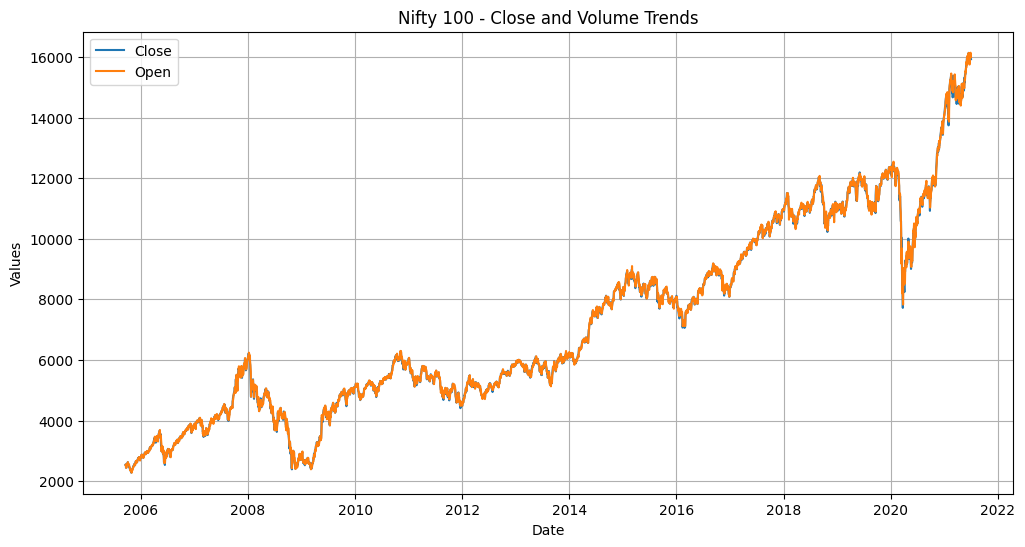

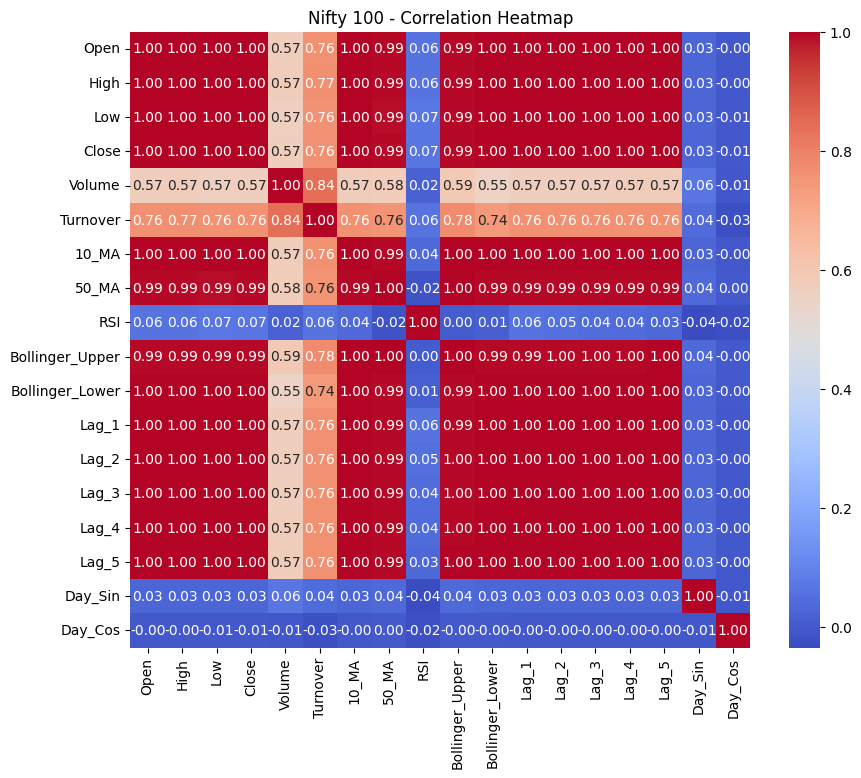

In [15]:
# Visualize 'Close' and 'Volume' trends
plot_time_series(nifty_data_cleaned, ['Close', 'Open'], f"Nifty 100 - Close and Volume Trends", "Values")

# Correlation heatmap
correlation_heatmap(nifty_data_cleaned, f"Nifty 100 - Correlation Heatmap")


# Applying LSTM 

In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Prepare data with multiple features
def prepare_data(data, feature_cols, target_col, lookback=60):
    """
    Prepares the data for LSTM with multiple features.
    :param data: The dataframe containing the features and target
    :param feature_cols: List of columns used as input features
    :param target_col: The column to predict
    :param lookback: Number of past days to use for predictions
    :return: X, y, feature_scaler, target_scaler
    """
    # Normalize the feature and target data
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    target_scaler = MinMaxScaler(feature_range=(0, 1))

    data_scaled_features = feature_scaler.fit_transform(data[feature_cols])
    data_scaled_target = target_scaler.fit_transform(data[[target_col]])

    X, y = [], []
    for i in range(lookback, len(data_scaled_features)):
        # Collect the lookback period data as features
        X.append(data_scaled_features[i - lookback:i, :])
        # Target is the next day's value
        y.append(data_scaled_target[i, 0])

    X, y = np.array(X), np.array(y)  # Reshape for LSTM
    return X, y, feature_scaler, target_scaler

# Prepare data with the required features
# Normalize features and target
feature_cols = ['High', 'Low', 'Close', 'Volume', '10_MA', '50_MA', 
                'RSI', 'Bollinger_Upper', 'Bollinger_Lower', 'Lag_1', 
                'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Day_Sin', 'Day_Cos']
target_col = 'Close' # Ensure all columns exist in the data

# Prepare the data
lookback = 15
X, y, feature_scaler, target_scaler = prepare_data(nifty_data_cleaned, feature_cols, target_col, lookback)

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [17]:
##### from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau

# Build the LSTM model
lstm_model = Sequential()

# Add LSTM layer
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.2))

# Add another LSTM layer
lstm_model.add(LSTM(units=100, return_sequences=False))
lstm_model.add(Dropout(0.2))

# Add Dense layer for prediction
lstm_model.add(Dense(units=1))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
##### from keras.callbacks import ReduceLROnPlateau

# Create a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Train the model with the learning rate scheduler
lstm_model.fit(X_train, y_train, epochs=120, batch_size=32, validation_data=(X_test, y_test), callbacks=[lr_scheduler])

Epoch 1/120
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0075 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 2/120
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 3/120
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.7993e-04 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 4/120
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.1502e-04 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 5/120
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.1223e-04 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 6/120
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.5263e-04 - val_loss: 0.0012 - learning_rate: 5.0000e-04
Epoch 7/120
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.6068e-04 - val_loss: 0.0021 - learning_rate: 5.0000e-04
Epoch 8/120
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.8778e-04 - val_loss: 0.0013 - learning_rate: 5.0000e-04
Epoch 9/120
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.4265e-04 - val_loss: 0.0013 - 

In [19]:
# Make predictions
predicted_scaled = lstm_model.predict(X_test)
predicted = target_scaler.inverse_transform(predicted_scaled)
actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Compare predictions with actuals
predictions_df = pd.DataFrame({'Actual': actual.flatten(), 'Predicted': predicted.flatten()})
print(predictions_df.head())

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
     Actual     Predicted
0  11095.00  11057.067383
1  11052.50  11061.804688
2  11131.95  11061.242188
3  11124.10  11072.693359
4  11113.70  11086.951172


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


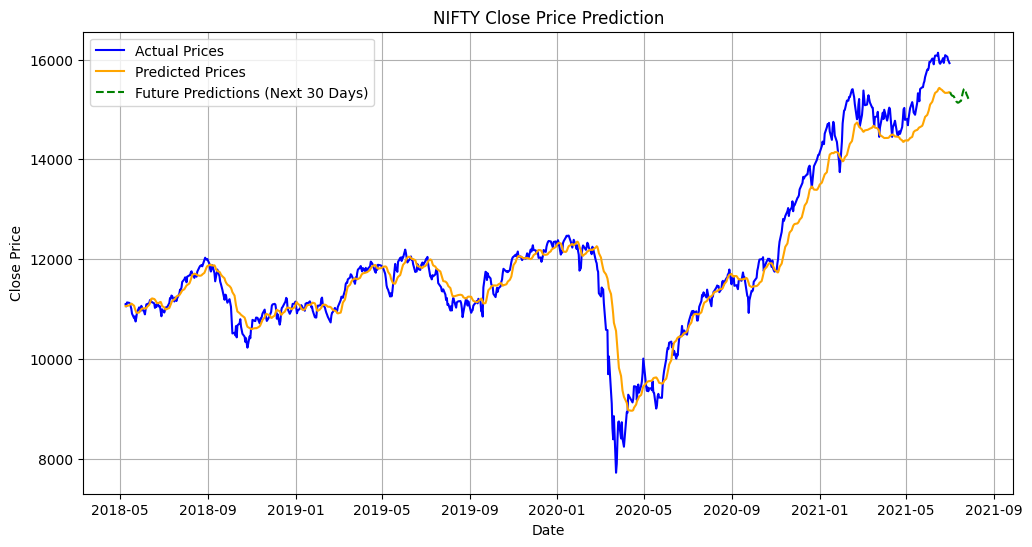

In [20]:
# Predict next 30 days
# Predict next 30 days
def predict_future(model, recent_data, scaler, steps=30):
    """
    Predicts the next `steps` days based on the LSTM model.
    :param model: Trained LSTM model
    :param recent_data: Last lookback days of scaled data
    :param scaler: MinMaxScaler used for the target
    :param steps: Number of future days to predict
    :return: List of predicted values (unscaled)
    """
    predictions = []
    input_data = recent_data.copy()  # Shape: (lookback, features)

    for _ in range(steps):
        # Predict the next step
        predicted_scaled = model.predict(input_data[np.newaxis, :, :], verbose=0)  # Shape: (1, 1)
        predicted_value = scaler.inverse_transform(predicted_scaled)[0, 0]
        predictions.append(predicted_value)

        # Update input_data: Shift rows and append the new prediction
        next_input = np.roll(input_data, -1, axis=0)  # Shift rows up
        next_input[-1, -1] = predicted_scaled[0, 0]  # Add new prediction to the last row's target column

        input_data = next_input

    return predictions

# Prepare recent data (last lookback days from test set)
recent_data = X_test[-1]

# Predict next 30 days
future_predictions = predict_future(lstm_model, recent_data, target_scaler, steps=30)

# Prepare graph data
actual_values = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
predicted_values = target_scaler.inverse_transform(lstm_model.predict(X_test)).flatten()
future_dates = pd.date_range(start=nifty_data_cleaned['Date'].iloc[-1] + pd.Timedelta(days=1), periods=30)

# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(nifty_data_cleaned['Date'].iloc[-len(actual_values):], actual_values, label="Actual Prices", color='blue')
plt.plot(nifty_data_cleaned['Date'].iloc[-len(predicted_values):], predicted_values, label="Predicted Prices", color='orange')
plt.plot(future_dates, future_predictions, label="Future Predictions (Next 30 Days)", color='green', linestyle='dashed')

plt.title("NIFTY Close Price Prediction")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.show()

# Applying Transformer

In [21]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

In [22]:
def sinusoidal_positional_encoding(seq_len, d_model):
    position = np.arange(seq_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pe = np.zeros((seq_len, d_model))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return torch.tensor(pe, dtype=torch.float32)


In [23]:
# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, n_heads, num_layers, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_layer = nn.Linear(input_dim, d_model)
        self.positional_encoding = sinusoidal_positional_encoding(1000, d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, src):
        device = src.device
        positional_encoding = self.positional_encoding.to(device)
        src = self.input_layer(src) + positional_encoding[: src.size(1), :]
        encoded = self.encoder(src)
        return self.output_layer(encoded[:, -1, :])  # Predicting the last step


# Prepare data for PyTorch
def prepare_data_pytorch(data, feature_cols, target_col, lookback=60):
    """
    Prepares data for PyTorch Transformer model.
    """
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    target_scaler = MinMaxScaler(feature_range=(0, 1))

    scaled_features = feature_scaler.fit_transform(data[feature_cols])
    scaled_target = target_scaler.fit_transform(data[[target_col]])

    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(scaled_features[i - lookback:i])
        y.append(scaled_target[i, 0])

    X, y = np.array(X), np.array(y)
    return X, y, feature_scaler, target_scaler

In [24]:
# Prepare data
X, y, feature_scaler, target_scaler = prepare_data_pytorch(nifty_data_cleaned, feature_cols, target_col, lookback=15)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert data to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Instantiate and train the Transformer model
input_dim = X.shape[2]
d_model = 128
n_heads = 8
num_layers = 4
dropout = 0.1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trsf_model = TransformerModel(input_dim, d_model, n_heads, num_layers, dropout).to(device)

from torch.optim.lr_scheduler import CyclicLR
criterion = nn.HuberLoss(delta=1.0)  # Huber Loss
optimizer = torch.optim.Adam(trsf_model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=200, mode='triangular')


In [25]:
epochs = 40
trsf_model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = trsf_model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        scheduler.step()  # Adjust learning rate

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader)}")


Epoch 1/40, Loss: 0.008452133786370407
Epoch 2/40, Loss: 0.0026942835244639987
Epoch 3/40, Loss: 0.0005675722751053696
Epoch 4/40, Loss: 0.0003402737845822323
Epoch 5/40, Loss: 0.0002943659887283242
Epoch 6/40, Loss: 0.0005447977296449719
Epoch 7/40, Loss: 0.0008257332705472102
Epoch 8/40, Loss: 0.0002304352057428926
Epoch 9/40, Loss: 0.00019913282746102242
Epoch 10/40, Loss: 0.00046220587311687934
Epoch 11/40, Loss: 0.0007608699830152731
Epoch 12/40, Loss: 0.00023278302221430694
Epoch 13/40, Loss: 0.000213476439967053
Epoch 14/40, Loss: 0.00026196582324218424
Epoch 15/40, Loss: 0.0004792325636692706
Epoch 16/40, Loss: 0.0002167514505010925
Epoch 17/40, Loss: 0.00016833925797165686
Epoch 18/40, Loss: 0.00027720276446008046
Epoch 19/40, Loss: 0.0007570358435370916
Epoch 20/40, Loss: 0.00022689166077298625
Epoch 21/40, Loss: 0.00016165828529498256
Epoch 22/40, Loss: 0.00025036629033690715
Epoch 23/40, Loss: 0.0004691007147348315
Epoch 24/40, Loss: 0.00021902981253723347
Epoch 25/40, Loss

In [26]:
# Evaluate the model
trsf_model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = trsf_model(X_batch)
        predictions.append(outputs.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

predictions = np.concatenate(predictions).flatten()
actuals = np.concatenate(actuals).flatten()

# Inverse transform predictions and actuals
predictions = target_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
actuals = target_scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()

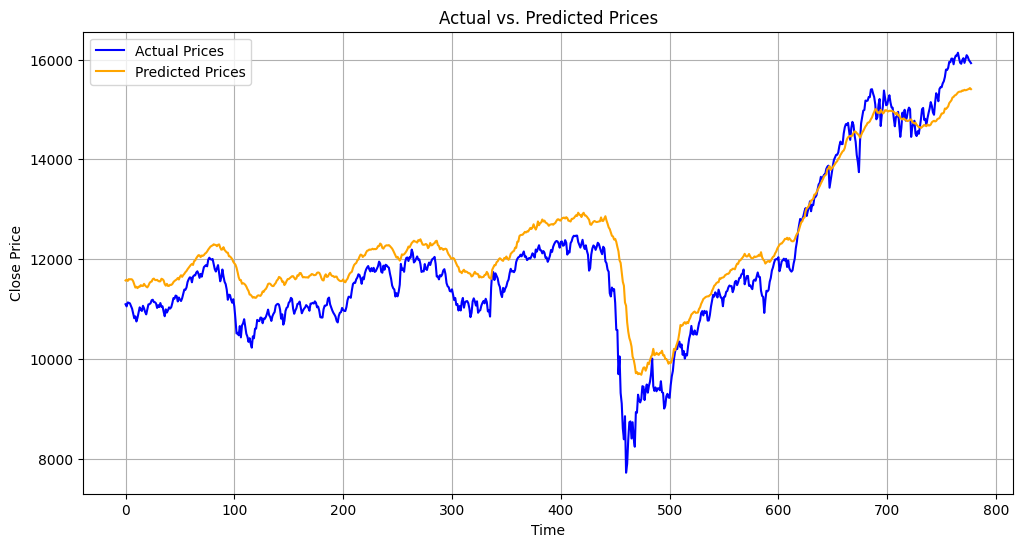

In [27]:
# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(actuals, label="Actual Prices", color='blue')
plt.plot(predictions, label="Predicted Prices", color='orange')
plt.title("Actual vs. Predicted Prices")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.show()

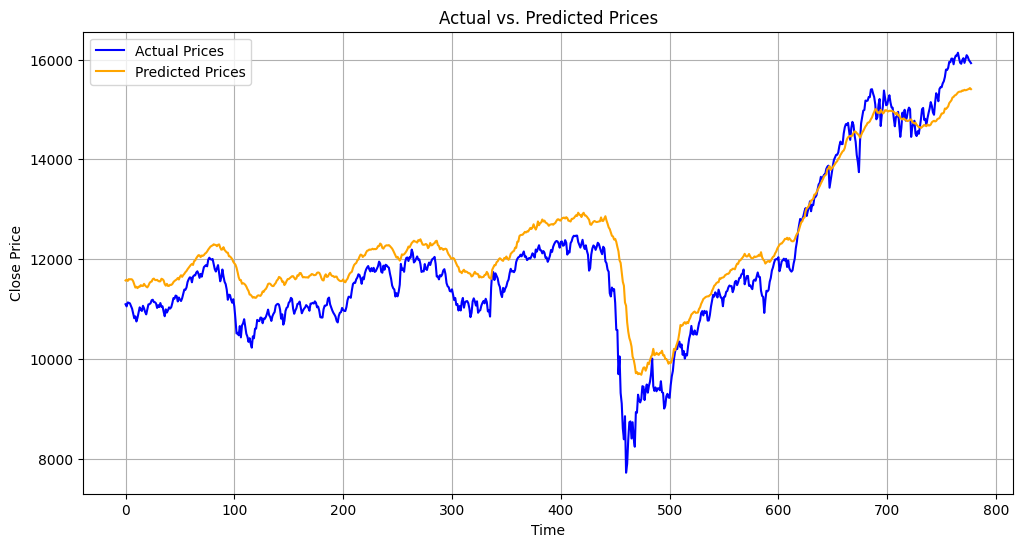

In [28]:
trsf_model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = trsf_model(X_batch)
        predictions.append(outputs.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

predictions = np.concatenate(predictions).flatten()
actuals = np.concatenate(actuals).flatten()

# Inverse transform predictions and actuals
predictions = target_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
actuals = target_scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()

plt.figure(figsize=(12, 6))
plt.plot(actuals, label="Actual Prices", color='blue')
plt.plot(predictions, label="Predicted Prices", color='orange')
plt.title("Actual vs. Predicted Prices")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.show()

# Ensemble

In [29]:
def ensemble_predictions(lstm_model, transformer_model, recent_data_lstm, recent_data_transformer, 
                          target_scaler, steps=1, weights=(0.5, 0.5)):
    """
    Ensembles predictions from LSTM and Transformer models.
    :param lstm_model: Trained LSTM model
    :param transformer_model: Trained Transformer model
    :param recent_data_lstm: Recent data input for LSTM
    :param recent_data_transformer: Recent data input for Transformer
    :param target_scaler: MinMaxScaler for target inverse transformation
    :param steps: Number of future steps to predict
    :param weights: Tuple of weights for combining predictions (LSTM, Transformer)
    :return: List of ensembled predictions
    """
    lstm_predictions = []
    transformer_predictions = []
    ensemble_predictions = []
    
    lstm_input = recent_data_lstm.copy()
    transformer_input = torch.tensor(recent_data_transformer, dtype=torch.float32).unsqueeze(0).to(device)

    for _ in range(steps):
        # LSTM prediction
        lstm_pred_scaled = lstm_model.predict(lstm_input[np.newaxis, :, :])
        lstm_pred = target_scaler.inverse_transform(lstm_pred_scaled)[0, 0]
        lstm_predictions.append(lstm_pred)

        # Update LSTM input
        lstm_next_input = np.roll(lstm_input, -1, axis=0)
        lstm_next_input[-1, -1] = lstm_pred_scaled[0, 0]
        lstm_input = lstm_next_input

        # Transformer prediction
        with torch.no_grad():
            transformer_pred_scaled = transformer_model(transformer_input).cpu().numpy().flatten()
            transformer_pred = target_scaler.inverse_transform(transformer_pred_scaled.reshape(-1, 1))[0, 0]
            transformer_predictions.append(transformer_pred)

            # Update Transformer input
            transformer_next_input = transformer_input.clone()
            transformer_next_input[:, 1:, :] = transformer_input[:, :-1, :]
            transformer_next_input[:, -1, -1] = torch.tensor(
                transformer_pred_scaled[0], dtype=torch.float32, device=device
            )
            transformer_input = transformer_next_input

        # Combine predictions using weights
        ensemble_pred = (weights[0] * lstm_pred) + (weights[1] * transformer_pred)
        ensemble_predictions.append(ensemble_pred)

    return ensemble_predictions, lstm_predictions, transformer_predictions

In [30]:
# Recent data
recent_data_lstm = X_test[-1]  # Last 60 days for LSTM
recent_data_transformer = X_test[-1]  # Same data for Transformer

# Predict next 30 days
future_ensemble_preds, lstm_preds, transformer_preds = ensemble_predictions(
    lstm_model=lstm_model,  # Trained LSTM model
    transformer_model=trsf_model,  # Trained Transformer model
    recent_data_lstm=recent_data_lstm,
    recent_data_transformer=recent_data_transformer,
    target_scaler=target_scaler,
    steps=30,
    weights=(0.5, 0.5)  # Equal weights for LSTM and Transformer
)

# Future dates
future_dates = pd.date_range(start=nifty_data_cleaned['Date'].iloc[-1] + pd.Timedelta(days=1), periods=30)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

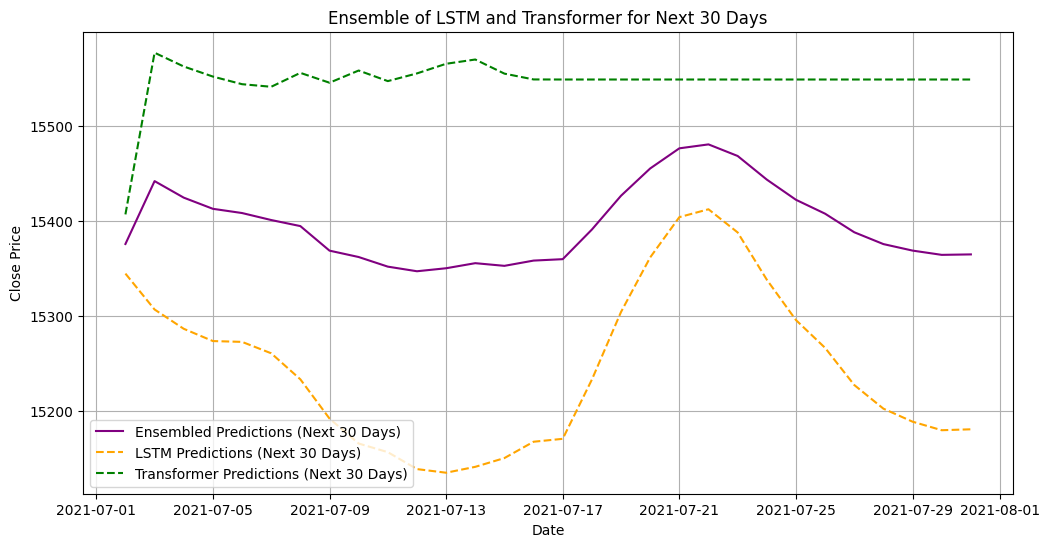

In [31]:
# Plot ensemble predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_ensemble_preds, label="Ensembled Predictions (Next 30 Days)", color='purple')
plt.plot(future_dates, lstm_preds, label="LSTM Predictions (Next 30 Days)", color='orange', linestyle='dashed')
plt.plot(future_dates, transformer_preds, label="Transformer Predictions (Next 30 Days)", color='green', linestyle='dashed')
plt.title("Ensemble of LSTM and Transformer for Next 30 Days")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Ensemble MSE: 204993.4601
Ensemble MAE: 312.6739


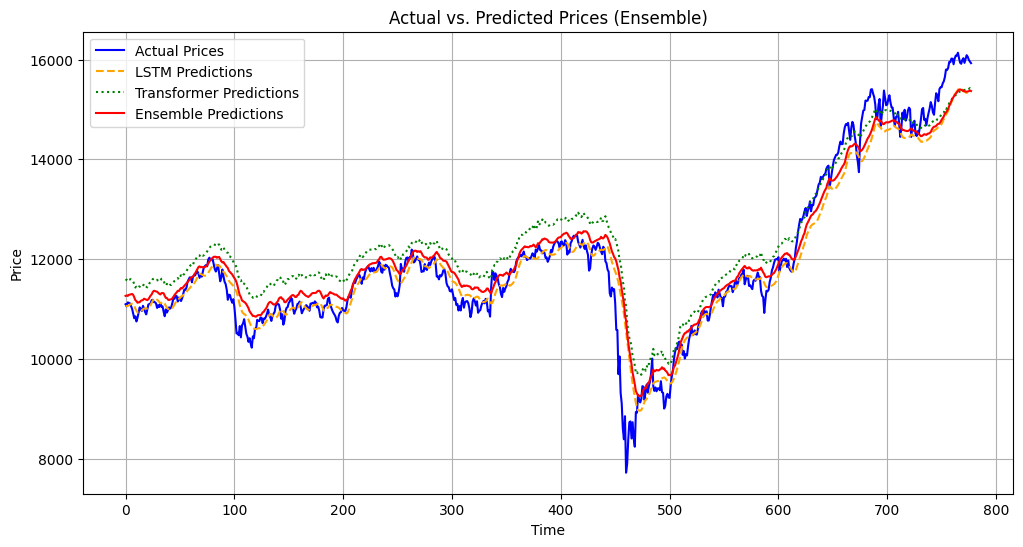

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define the ensemble function
def ensemble_predictions(lstm_preds, transformer_preds, lstm_weight=0.5, transformer_weight=0.5):
    """
    Combine predictions from LSTM and Transformer models using weighted averaging.
    :param lstm_preds: Predictions from the LSTM model.
    :param transformer_preds: Predictions from the Transformer model.
    :param lstm_weight: Weight for LSTM predictions.
    :param transformer_weight: Weight for Transformer predictions.
    :return: Final ensemble predictions.
    """
    assert len(lstm_preds) == len(transformer_preds), "Predictions must have the same length"
    lstm_weight = lstm_weight / (lstm_weight + transformer_weight)  # Normalize weights
    transformer_weight = 1 - lstm_weight
    return (lstm_weight * np.array(lstm_preds)) + (transformer_weight * np.array(transformer_preds))

# Generate LSTM predictions
lstm_preds = lstm_model.predict(X_test)  # LSTM predictions (already implemented)

# Generate Transformer predictions
transformer_preds = []
with torch.no_grad():
    for X_batch in torch.tensor(X_test, dtype=torch.float32).to(device):  # Assuming X_test is the Transformer input
        transformer_preds.append(trsf_model(X_batch.unsqueeze(0)).cpu().numpy())
transformer_preds = np.concatenate(transformer_preds).flatten()

# Inverse transform predictions and actuals for evaluation
lstm_preds = target_scaler.inverse_transform(lstm_preds.reshape(-1, 1)).flatten()
transformer_preds = target_scaler.inverse_transform(transformer_preds.reshape(-1, 1)).flatten()
actuals = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()  # Assuming y_test is scaled

# Perform ensembling
ensemble_preds = ensemble_predictions(lstm_preds, transformer_preds, lstm_weight=0.6, transformer_weight=0.4)

# Evaluate predictions
mse = mean_squared_error(actuals, ensemble_preds)
mae = mean_absolute_error(actuals, ensemble_preds)

print(f"Ensemble MSE: {mse:.4f}")
print(f"Ensemble MAE: {mae:.4f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(actuals, label="Actual Prices", color='blue')
plt.plot(lstm_preds, label="LSTM Predictions", color='orange', linestyle='dashed')
plt.plot(transformer_preds, label="Transformer Predictions", color='green', linestyle='dotted')
plt.plot(ensemble_preds, label="Ensemble Predictions", color='red')
plt.title("Actual vs. Predicted Prices (Ensemble)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()
